# NBA Data :: Principal Component Analysis

Trevor Rowland - 2/27/25

This notebook aims to create a Principal Component Analysis (PCA) to identify important features and reduce the size of the dataset.

The dataset we will be using is the `games_merged_endpoints.csv` file, which can be accessed with the following code block. Going forwards, this dataset and the reduced dataset from the PCA will be used. The README file will be updated to reflect this change.

The tutorial I followed to create this PCA can be found [here](<https://builtin.com/machine-learning/pca-in-python>).

In [36]:
import pandas as pd

gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

In [37]:
print(df.columns.tolist())

['game_id', 'season', 'team_id', 'team_name', 'tri_code', 'team_slug', 'minutes', 'field_goals_made', 'field_goals_attempted', 'field_goals_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_pointers_percentage', 'free_throws_made', 'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive', 'rebounds_defensive', 'rebounds_total', 'steals', 'blocks', 'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'estimated_offensive_rating', 'offensive_rating', 'estimated_defensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_percentage', 'assist_to_turnover', 'assist_ratio', 'offensive_rebound_percentage', 'defensive_rebound_percentage', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'usage_percentage', 'estimated_usage_percentage', 'estimated_pace', 'pace', 'pace_per40', 'possessions', 'p_i_e', 'distance', 'rebound_chances_offensi

## 0. Identifying a Target Variable

Before performing any PCA tasks, we must first identify a **target variable**. The PCA tool requires a split between response and predictor variables, so a target must be chosen. This will be done by assessing the correlations between variables, and a variable with the highest correlation across predictor variables is a good place to start for a target.

<Axes: >

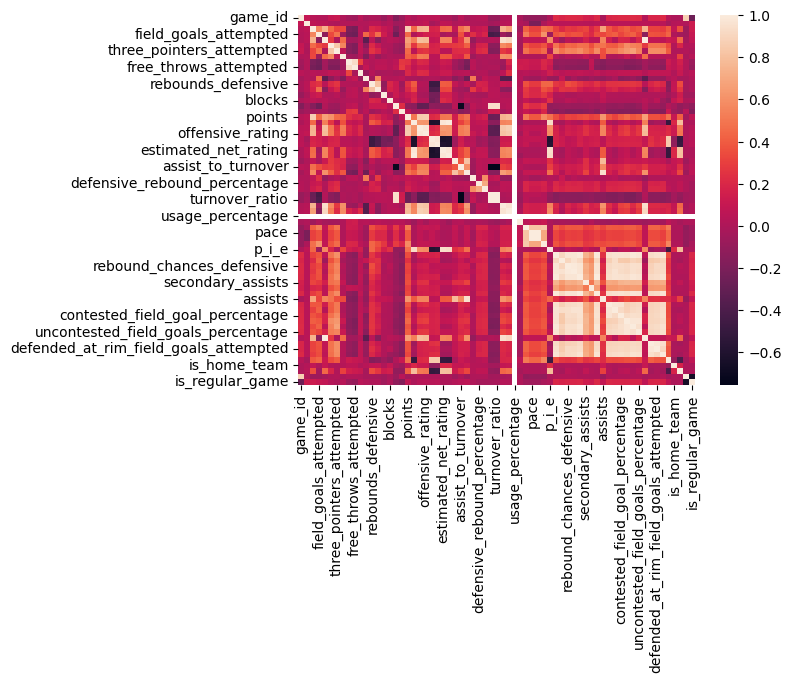

In [38]:
import seaborn as sns
%matplotlib inline

# load the Auto dataset

# calculate the correlation matrix on the numeric columns
corr = df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

This chart is fairly inconclusive. After a meeting, we were told to first investigate points per game (PPG), or `points` in our dataset.

In [39]:
corr['points'].sort_values(ascending=False)

points                                1.000000
field_goals_made                      0.863314
offensive_rating                      0.854265
estimated_offensive_rating            0.843106
true_shooting_percentage              0.774678
                                        ...   
is_playoff_game                      -0.045072
turnovers                            -0.119722
turnover_ratio                       -0.266647
estimated_team_turnover_percentage   -0.267045
usage_percentage                           NaN
Name: points, Length: 67, dtype: float64

In [40]:
corr['opponent_points'].sort_values(ascending=False)

opponent_points               1.000000
defensive_rating              0.847144
estimated_defensive_rating    0.842728
possessions                   0.561679
estimated_pace                0.511566
                                ...   
p_i_e                        -0.471028
estimated_net_rating         -0.496828
plus_minus_points            -0.497960
net_rating                   -0.505641
usage_percentage                   NaN
Name: opponent_points, Length: 67, dtype: float64

From this we have 2 options. We can either investigate home team points (`points`) further, or we can examine what is making away teams win more `opponent_points`. Let's focus on team points for now, and examine away teams only if necessary.

This makes our target variable `points`, and the predictor variables are the rest of the numeric variables in the dataset.

## 1. Scale the Data

To perform the PCA, data must first be scaled to standardize it to have a mean of 0, and a standard deviation of 1. This will be done with `sklearn`'s `StandardScaler` tool. Additionally, ID values like `game_id`, `team_id`, etc. will be filtered out.

In [41]:
df_numeric = df.select_dtypes('number')
df_numeric.head()

pca_df = df_numeric.drop(['game_id','team_id','is_home_team','won_game','is_playoff_game','is_regular_game'], axis=1)

pca_df = pca_df.dropna()

pca_df.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points
0,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,...,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0
1,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,...,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0
2,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,...,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0
3,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,...,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0
4,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,...,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0


In [42]:
print(pca_df.columns.tolist())

['field_goals_made', 'field_goals_attempted', 'field_goals_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_pointers_percentage', 'free_throws_made', 'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive', 'rebounds_defensive', 'rebounds_total', 'steals', 'blocks', 'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'estimated_offensive_rating', 'offensive_rating', 'estimated_defensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_percentage', 'assist_to_turnover', 'assist_ratio', 'offensive_rebound_percentage', 'defensive_rebound_percentage', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'usage_percentage', 'estimated_usage_percentage', 'estimated_pace', 'pace', 'pace_per40', 'possessions', 'p_i_e', 'distance', 'rebound_chances_offensive', 'rebound_chances_defensive', 'rebound_chances_total', 'touches', 'secondary_

Now we can begin the PCA process. Let's scale the data with `StandardScaler`.

In [43]:
from sklearn.preprocessing import StandardScaler

response = ['points']
predictors = ['field_goals_made', 
    'field_goals_attempted', 
    'field_goals_percentage', 
    'three_pointers_made', 
    'three_pointers_attempted', 
    'three_pointers_percentage', 
    'free_throws_made', 
    'free_throws_attempted', 
    'free_throws_percentage', 
    'rebounds_offensive', 
    'rebounds_defensive', 
    'rebounds_total', 
    'steals', 
    'blocks', 
    'turnovers', 
    'fouls_personal',
    'plus_minus_points', 
    'estimated_offensive_rating', 
    'offensive_rating', 
    'estimated_defensive_rating', 
    'defensive_rating', 
    'estimated_net_rating', 
    'net_rating', 
    'assist_percentage', 
    'assist_to_turnover', 
    'assist_ratio', 
    'offensive_rebound_percentage', 
    'defensive_rebound_percentage', 
    'rebound_percentage', 
    'estimated_team_turnover_percentage',
    'turnover_ratio', 
    'effective_field_goal_percentage', 
    'true_shooting_percentage', 
    'usage_percentage', 
    'estimated_usage_percentage', 
    'estimated_pace', 
    'pace', 
    'pace_per40', 
    'possessions', 
    'p_i_e', 
    'distance', 
    'rebound_chances_offensive', 
    'rebound_chances_defensive', 
    'rebound_chances_total', 
    'touches', 
    'secondary_assists', 
    'free_throw_assists', 
    'passes', 
    'assists', 
    'contested_field_goals_made', 
    'contested_field_goals_attempted', 
    'contested_field_goal_percentage', 
    'uncontested_field_goals_made', 
    'uncontested_field_goals_attempted', 
    'uncontested_field_goals_percentage', 
    'field_goal_percentage', 
    'defended_at_rim_field_goals_made', 
    'defended_at_rim_field_goals_attempted', 
    'defended_at_rim_field_goal_percentage', 
    'opponent_points'
]

# Split the DF

x = pca_df.loc[:, predictors].values
y = pca_df.loc[:,response].values

x = StandardScaler().fit_transform(x)


In [44]:
pca_df.columns.value_counts().sum()

61

Now that the features have been scaled, we can begin the dimensionality reduction.

# 2. PCA Projection to 2D

The dataframe `pca_df` currently has 61 total columns, or **60 predictor variables**. I am assuming that we need to reduce this into 2 dimensions like in the tutorial.

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2'])

In [47]:
finalDf = pd.concat([principalDf, df[['points']]], axis=1)
finalDf.head()

,pc1,pc2,points
0,-6.155107,1.094520,81.0
1,-5.582643,-1.832755,86.0
2,-5.561167,-0.060261,95.0
3,-3.710294,5.213980,102.0
4,-4.690338,2.859864,96.0


## 3. Visualizing the 2D Projection

Now we can plot the dimensionally-reduced data.

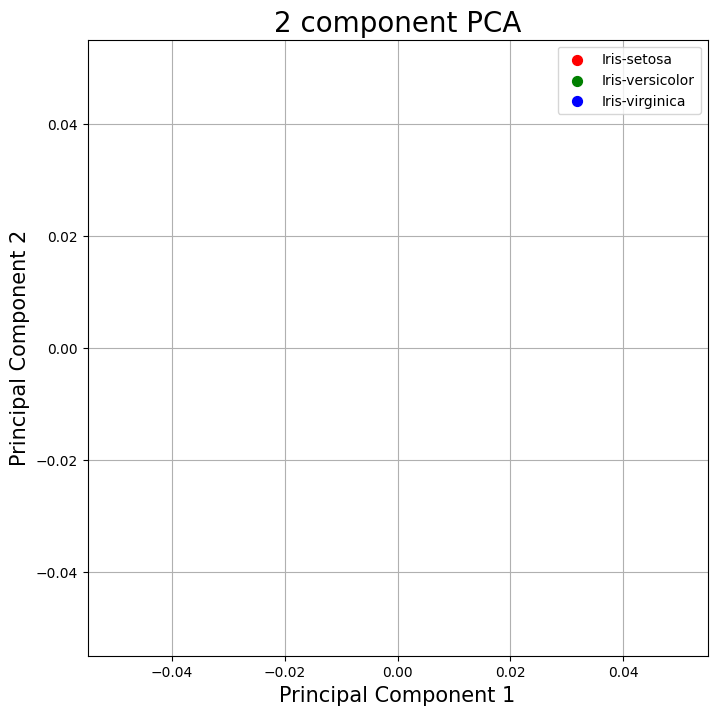

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] # What do I replace this with?
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['points'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()